In [1]:
%reset
%matplotlib inline

import netCDF4 as nc
import cmocean
import numpy as np
import xarray as xr
import xrft
from xgcm import Grid
import matplotlib.pyplot as plt
import scipy.interpolate
from dask.diagnostics import ProgressBar
from matplotlib import colors, ticker
import pandas as pd

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/
forcing=xr.open_dataset('NW2_forcing.nc', decode_times=False) #This is for the 1/8 degree case


# # #1/4 degree resolution, surface diagnostics are for uppermost 5 meters.
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.25deg_N15_baseline_hmix5/
# fs = xr.open_dataset('static.nc', decode_times=False)
# os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc'], decode_times=False)
# av = xr.open_dataset('averages_00031502.nc', decode_times=False)  #100 5-day averages


#1/32 degree resolution, surface diagnostics are for uppermost 5 meters.
%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.03125deg_N15_baseline_hmix5
fs = xr.open_dataset('static.nc', decode_times=False)
os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc','sub03/ocean.stats.nc','sub04/ocean.stats.nc',
                        'sub05/ocean.stats.nc','sub06/ocean.stats.nc','sub07/ocean.stats.nc','sub08/ocean.stats.nc'], decode_times=False)
av = xr.open_dataset('averages_00002702.nc', decode_times=False)  #20 5-day averages
#av = xr.open_mfdataset(['averages_00002302.nc','averages_00002402.nc','averages_00002502.nc','averages_00002602.nc','averages_00002702.nc'], decode_times=False)  #20 5-day averages

%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis
/glade/campaign/univ/unyu0004/NeverWorld2/nw2_0.03125deg_N15_baseline_hmix5
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [11]:
lat= (av.yh)     
lon= (av.xh)     

grid= Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});

Ld = av.Rd1[:].mean('time').mean('xh')/1000

In [29]:
lat_full = fs['geolat']
SSH = (av['h'][:,:,:,:]).sum('zl')-(av['h'][:,:,:,:]).sum('zl').mean('time');
print('done')
dSSHdx = SSH.differentiate('xh')*360/(6370000*2*np.pi*np.cos(lat_full*np.pi/180))
dSSHdy = SSH.differentiate('yh')*360/(6370000*2*np.pi)

numerator = (SSH**2).mean('time'); numerator = numerator.where(numerator>0)
denominator = ((abs(dSSHdy))**2+(abs(dSSHdx))**2).mean('time'); denominator = denominator.where(denominator>0e-20)
scale = ((numerator/denominator)**0.5).mean('xh')
scale = scale[80:-80]/1000
scale[0:10]=np.nan

done


(4480,)

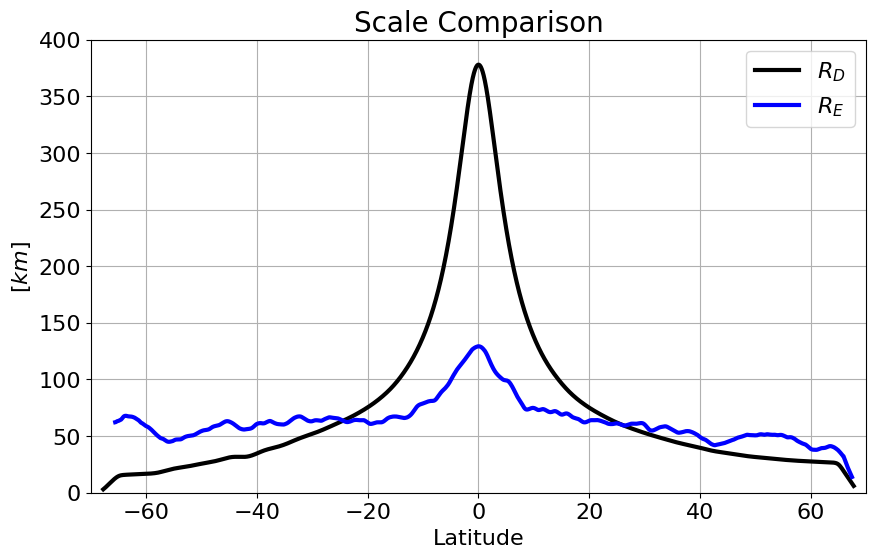

In [30]:

fig, ax = plt.subplots(figsize=(10,6),dpi=100)

window=100
smooth_scale=np.convolve(scale, np.ones((window,))/window, mode='same')
smooth_Ld=np.convolve(Ld, np.ones((window,))/window, mode='same')
smooth_scale_stdev     =np.convolve(scale_stdev, np.ones((window,))/window, mode='same')




plt.plot(Ld.yh,smooth_Ld,'-',c='k',linewidth=3,label='$R_D$')
plt.plot(scale.yh,smooth_scale,'-',c='b',linewidth=3,label='$R_E$')

#plt.plot(scale.yh,smooth_scale,'-',c='#FF5733',linewidth=3,label='$R_E$')


plt.title('Scale Comparison',fontsize=20)
plt.ylim([0, 400]); plt.xticks(fontsize=16);
plt.xlim([-70, 70]); plt.yticks(fontsize=16);
plt.grid()
plt.xlabel('Latitude',fontsize=16); plt.ylabel('$[km]$',fontsize=16);
plt.legend(fontsize=16)

#ax.set_xlabel(r'k [1/km]')
#ax.set_ylabel(r'[m$^3$ s$^{-2}$]')

In [19]:
#COMPUTE velocity components for decomposing KE:
Nlayers=15

h  = av['h'].mean('time').fillna(0.)
Depth=h.sum('zl')
print('done part 1')
#Outputs are comprised of 100 5-day averages.
u  = av['u'];  u = grid.interp(u,axis='X')#.fillna(0.); 
ubar=u.mean('time')
print('done part 2')
v  = av['v'];  v = grid.interp(v,axis='Y')#.fillna(0.);
vbar=v.mean('time')

uprime=u-ubar
vprime=v-vbar

print(uprime.shape)
area_t=fs['area_t']

done part 1
done part 2
(20, 15, 4480, 1920)


In [20]:
# The mean BT and BC KE values:
ubar_TW=ubar*h/Depth; 
ubar_BT=ubar_TW.sum('zl')
ubar_BC=ubar-ubar_BT;

vbar_TW=vbar*h/Depth
vbar_BT=vbar_TW.sum('zl')
vbar_BC=vbar-vbar_BT;

KE_mean_BT=0.5*(vbar_BT**2+ubar_BT**2) #dim y,x
KE_mean_BC=(0.5*(vbar_BC**2+ubar_BC**2)*h/Depth).sum('zl') #dim y,x
print('done 1')

#Eddy BT and BC KE parts:
uprime_BT=(uprime*h/Depth).sum('zl')
uprime_BC=uprime-uprime_BT
vprime_BT=(vprime*h/Depth).sum('zl')
vprime_BC=vprime-vprime_BT
    
KE_eddy_BT=(0.5*(vprime_BT**2+uprime_BT**2)).mean('time')
KE_eddy_BC=((0.5*(vprime_BC**2+uprime_BC**2)*h/Depth).sum('zl')).mean('time')

print('done 2')
# #Total kinetic energy:
KE_BT_tot=KE_eddy_BT+KE_mean_BT
KE_BC_tot=KE_eddy_BC+KE_mean_BC
KE_tot=KE_BT_tot+KE_BC_tot


fraction_BT=KE_BT_tot/KE_tot
fraction_BT_mean=KE_mean_BT/KE_tot
fraction_BT_eddy=KE_eddy_BT/KE_tot

fraction_BC=KE_BC_tot/KE_tot#when you divide zero/zero it's a nan
fraction_BC_mean=KE_mean_BC/KE_tot
fraction_BC_eddy=KE_eddy_BC/KE_tot

KE_eddy = KE_eddy_BT+ KE_eddy_BC
KE_mean = KE_mean_BT+ KE_mean_BC

done 1
done 2


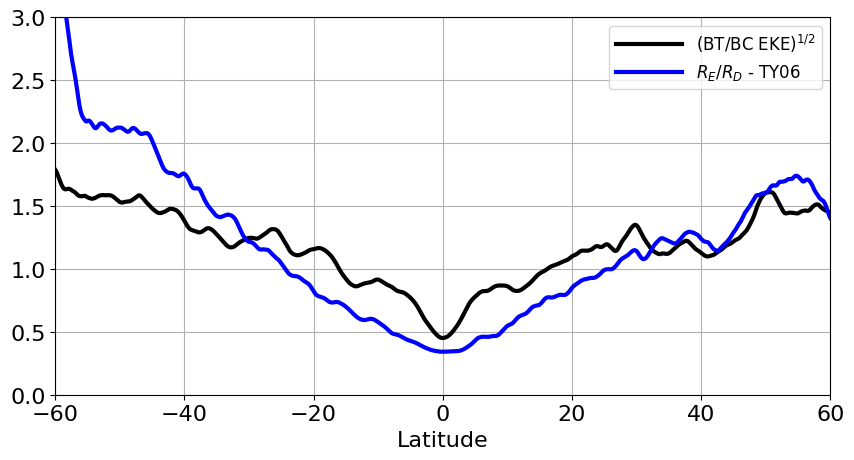

In [31]:
window=100; lim=80

plt.figure(figsize=(10, 5), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
yh_center=av.yh[lim:-lim]
Eddy_BC=(KE_eddy_BC.mean('xh'))[lim:-lim];
Eddy_BT=(KE_eddy_BT.mean('xh'))[lim:-lim];

BT_BC=np.convolve((Eddy_BT/Eddy_BC)**0.5, np.ones((window,))/window, mode='same')

LEscale_LD=np.convolve((scale/Ld), np.ones((window,))/window, mode='same')

bound1=80; bound2=-80
plt.plot(yh_center[bound1:bound2],BT_BC[bound1:bound2],'-',c='k',linewidth=3)


plt.plot(yh_center[bound1:bound2],LEscale_LD[bound1:bound2],'-',c='b',linewidth=3)


plt.legend(['(BT/BC EKE)$^{1/2}$','$R_E/R_D$ - TY06'],loc='upper right',fontsize=12,handlelength=4)
#plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.ylim([0, 3]); plt.xticks(fontsize=16);
plt.xlim([-60, 60]); plt.yticks(fontsize=16);
plt.xlabel('Latitude',fontsize=16)
#plt.ylabel('Fraction')
#plt.title('1/32$^\circ$')
plt.grid()

In [25]:
smooth_Ld.shape

(4480,)